# Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler 
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.feature_selection import RFECV

%matplotlib inline

# Read data and only keep needed class

In [2]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [3]:
user_tr = user[pd.notnull(user['Sale_MF'])]
print(user_tr.shape)

(937, 41)


In [4]:
user_tr = user_tr.drop(['Sale_MF','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)


In [5]:
user_tr_X = user_tr.drop('Sale_CC', axis=1)

user_tr_Y = user_tr['Sale_CC']

## Check target data set

(937, 35)


(array([ 706.,  231.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

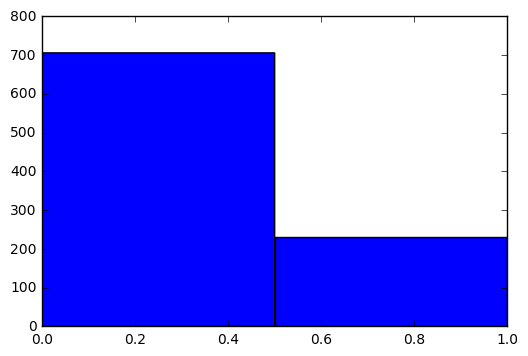

In [6]:
print(user_tr_X.shape)
plt.hist(user_tr_Y, bins=2)

It is clear the data is inbalanced in favor of the 0. This will be solved in the preprocessing step by adding random
rows with class 1 untill the data is balanced.

## Missing data

In [7]:
#missing data
total = user_tr_X.isnull().sum().sort_values(ascending=False)
percent = (user_tr_X.isnull().sum()/user_tr_X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
ActBal_CL_avg,0,0.0
Count_CL,0,0.0
ActBal_CL,0,0.0
ActBal_CC,0,0.0
ActBal_OVD,0,0.0
ActBal_MF,0,0.0
ActBal_SA,0,0.0
ActBal_CA,0,0.0
Count_CC,0,0.0
VolumeCred_CA,0,0.0


# Preprocessing of the data

## check for skewness and log transform if needed

In [8]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

In [9]:
user_tr_X.replace(np.NaN, 0, inplace=True)

## Remove outliers

This was already done during EDA for the most extreme cases. I have added this code for further outlier removal but this did not improve the performance of the models.
This because the code assumes a normal distribution and most of the data is not distributed like this.

In [10]:
#for col in user_tr_X.columns:
#    index = user_tr_X[np.abs(user_tr_X[col]-user_tr_X[col].mean())>(3*user_tr_X[col].std())].index.values
#    user_tr_X.drop(index, inplace = True)
#    user_tr_Y.drop(index, inplace = True)

## Upsampling

Upsampling is done to fix the class imbalance

In [11]:
ros = RandomOverSampler(random_state=42)
user_tr_X, user_tr_Y = ros.fit_sample(user_tr_X,user_tr_Y)

# Model selection

Different models will be tested using cross validation based on the roc auc

## Test with basic data

In [12]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



roc_auc: 0.62 (+/- 0.08)


In [13]:
random_forest = RandomForestClassifier(n_estimators = 20)
scores = cross_val_score(random_forest, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.9719 (+/- 0.08)


In [14]:
gaussian = GaussianNB()
scores = cross_val_score(gaussian, user_tr_X, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.61 (+/- 0.09)


## Scale the data for support vector algo

In [15]:
#Scale the data
user_tr_X_scale = scale(user_tr_X)

In [16]:
svc = SVC(kernel='rbf', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

roc_auc: 0.82 (+/- 0.09)
[ 0.75699266  0.74151954  0.76810157  0.86153541  0.83872248  0.8623289
  0.84918367  0.85612245  0.80244898  0.83020408]


In [17]:
svc = SVC(kernel='linear', degree=2, random_state=101)
scores = cross_val_score(svc, user_tr_X_scale, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print(scores)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



[ 0.65522714  0.60979964  0.55227137  0.66177346  0.64391986  0.70085301
  0.61612245  0.59204082  0.57673469  0.6677551 ]
roc_auc: 0.63 (+/- 0.09)


## PCA

Some PCA is done to see if this might improve the model. 
The number of dimensions to keep is based on the correlation done in the EDA

In [18]:
#dimension reduction
pca = PCA(n_components=8)
X_pca_20 = pca.fit_transform(user_tr_X)
X_pca_20.shape

(1412, 8)

In [19]:
random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, X_pca_20, user_tr_Y, cv=10, scoring='roc_auc', n_jobs=-1)
print("roc_auc: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: 0.9601 (+/- 0.09)


## Result

### It is clear the randomforest algo is the best algo for the classification. This will be futher optimised and used for the prediction

# Optimize the algorithm

In [20]:
search = { "n_estimators"      : [10, 20, 50],
           "criterion"         : ["gini", "entropy"],
           "max_features"      : [3, 5, 10],
           "max_depth"         : [10, 20,30],
           "min_samples_split" : [2, 4] ,
           "bootstrap": [True, False]}


randfor = RandomForestClassifier()

randfor_grid = GridSearchCV(estimator=randfor,param_grid=search, scoring='roc_auc', n_jobs=-1,refit=True, cv=10)

randfor_grid.fit( user_tr_X, user_tr_Y)

print(randfor_grid.best_estimator_)

print(randfor_grid.best_params_)

print(randfor_grid.best_score_)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=30, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
{'criterion': 'gini', 'max_depth': 30, 'bootstrap': False, 'n_estimators': 20, 'min_samples_split': 2, 'max_features': 3}
0.984030243786


# Fit the model and predict the missing values

Get the values to predict

In [21]:
user_pr = user[pd.isnull(user['Sale_MF'])]
print(user_pr.shape)

(629, 41)


In [22]:
user_pr = user_pr.drop(['Sale_MF','Sale_CL','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)

In [23]:
user_pr_Y = randfor_grid.predict( user_pr)

In [24]:
user_pr['Sale_CC_pred'] = pd.Series(user_pr_Y,index=user_pr.index)

(array([ 395.,  234.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

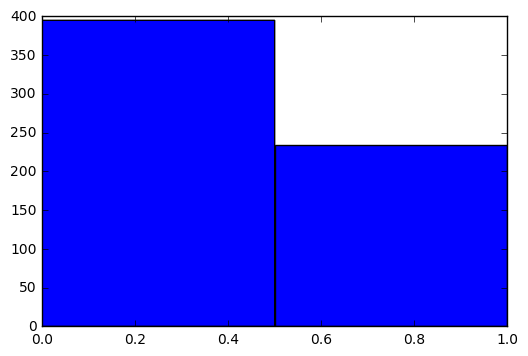

In [25]:
plt.hist(user_pr_Y, bins=2)

In [26]:
user_pr.to_csv(path_or_buf='credit_card_prop_pred.csv')